In [1]:
import pandas as pd
import prepare
import explore
import matplotlib.pyplot as plt

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn.model_selection

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import scipy.stats as stats
from scipy.stats import norm, binom, pearsonr
from collections import Counter

In [2]:
df = prepare.get_data('all_books.csv')

In [3]:
prepare.clean_article(df, 'title')
prepare.clean_article(df, 'summary')

In [4]:
df1 = pd.read_csv('books_feat_on_NYBS.csv', index_col=0)
prepare.clean_article(df1, 'Book')
ser = df1['cleaned_Book']
prepare.creat_tar(df, ser)
df['lemmatized_summary'] = df['cleaned_summary'].apply(prepare.lemmatize_text)
df[['neg', 'neutral', 'pos', 'compound']] = df['summary'].apply(prepare.feat_sent)
df['sentiment'] = df['compound'].apply(prepare.get_sentiment)

In [5]:
train,test = explore.split(df,'successful')

In [48]:
def get_most_common_negative_ngrams(train, n, top_n):
    '''
        Returns a Pandas DataFrame with the most common n-grams for negative reviews in the given train dataset.
    
        Params:
        --------
            train (Pandas DataFrame): 
                The dataset to extract the negative reviews from.
            n (int): 
                The n-gram size to extract (1 for unigrams, 2 for bigrams, 3 for trigrams).
            top_n (int): 
                The number of rows to return with the most common n-grams.

        Returns:
        --------
            A Pandas DataFrame with two columns: 
                the n-gram words and their frequency count. 
                
            The DataFrame has a total of top_n rows, which are the most 
            common n-grams in the negative reviews. The name of the columns depend on the
            n-gram size.

    '''
    # Subset df split of train into only negative values of 'sentiment' column
    df_neg = train[train['sentiment'].isin(['negative', 'very negative'])]
    
    # Tokenize words
    words = df_neg['cleaned_summary'].str.lower().str.cat(sep=' ').split()

    # Create a list of additional stopwords
    additional_stopwords = ['.']

    # Add the additional stopwords to the default set of stopwords
    stop_words = set(stopwords.words('english') + additional_stopwords)

    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # Get frequency distribution of ngrams
    if n == 1:
        freq_dist = nltk.FreqDist(words)
        most_common = freq_dist.most_common(top_n)
        df_common = pd.DataFrame(most_common, columns=['Words', 'Frequency'])
    elif n == 2:
        freq_dist_bigram = nltk.FreqDist(nltk.bigrams(words))
        most_common = freq_dist_bigram.most_common(top_n)
        df_common = pd.DataFrame(most_common, columns=['Bigrams', 'Frequency'])
    elif n == 3:
        freq_dist_trigram = nltk.FreqDist(nltk.trigrams(words))
        most_common = freq_dist_trigram.most_common(top_n)
        df_common = pd.DataFrame(most_common, columns=['Trigrams', 'Frequency'])
    else:
        print('Invalid value for n')

    return df_common

In [51]:
top_15_negative_words_df = get_most_common_negative_ngrams(train,1,15)
top_15_negative_bigrams_df = get_most_common_negative_ngrams(train,2,15)
top_15_negative_trigrams_df = get_most_common_negative_ngrams(train,3,15)

In [65]:
for i in top_15_negative_words_df['Frequency']:
    print(i)

799
617
451
394
326
297
294
272
260
247
244
242
242
241
226


In [62]:
for i in top_15_negative_words_df['Words']:
    print(i)

one
new
life
world
story
two
must
even
first
find
never
years
war
young
family


In [67]:
for i in top_15_negative_bigrams_df['Frequency']:
    print(i)

165
97
77
72
51
38
35
35
33
25
25
22
22
21
21


In [63]:
for i in top_15_negative_bigrams_df['Bigrams']:
    print(i)

('new', 'york')
('york', 'times')
('bestselling', 'author')
('times', 'bestselling')
('world', 'war')
('eve', 'dallas')
('1', 'new')
('cover', 'edition')
('alternate', 'cover')
('young', 'woman')
('lieutenant', 'eve')
('high', 'school')
('one', 'thing')
('new', 'york,')
('small', 'town')


In [68]:
for i in top_15_negative_trigrams_df['Frequency']:
    print(i)

95
72
47
35
24
16
15
13
13
12
11
10
9
8
7


In [61]:
for i in top_15_negative_trigrams_df['Trigrams']:
    print(i)

('new', 'york', 'times')
('york', 'times', 'bestselling')
('times', 'bestselling', 'author')
('1', 'new', 'york')
('alternate', 'cover', 'edition')
('lieutenant', 'eve', 'dallas')
('new', 'york', 'city')
('note', 'alternate', 'cover')
('world', 'war', 'ii')
('cover', 'edition', 'isbn')
('world', 'war', 'ii,')
('cover', 'edition', 'found')
("librarian's", 'note', 'alternate')
('tour', 'de', 'force')
('new', 'york', 'city,')


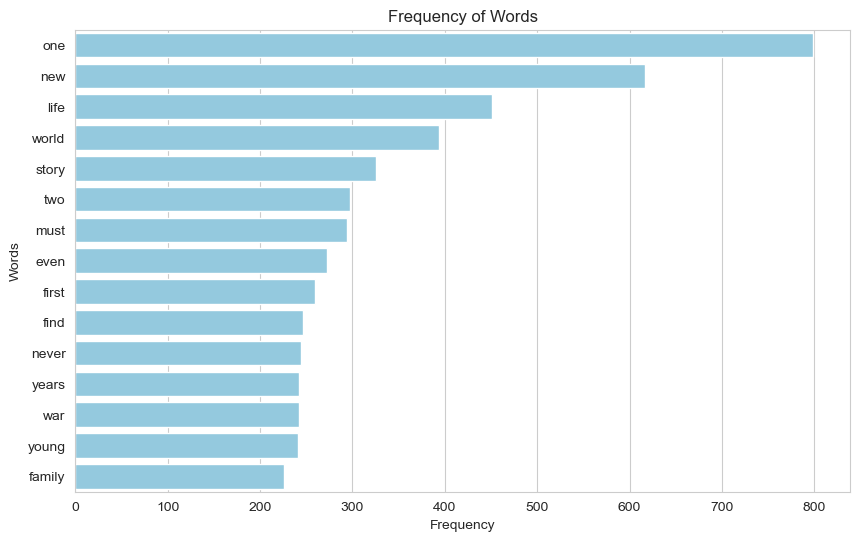

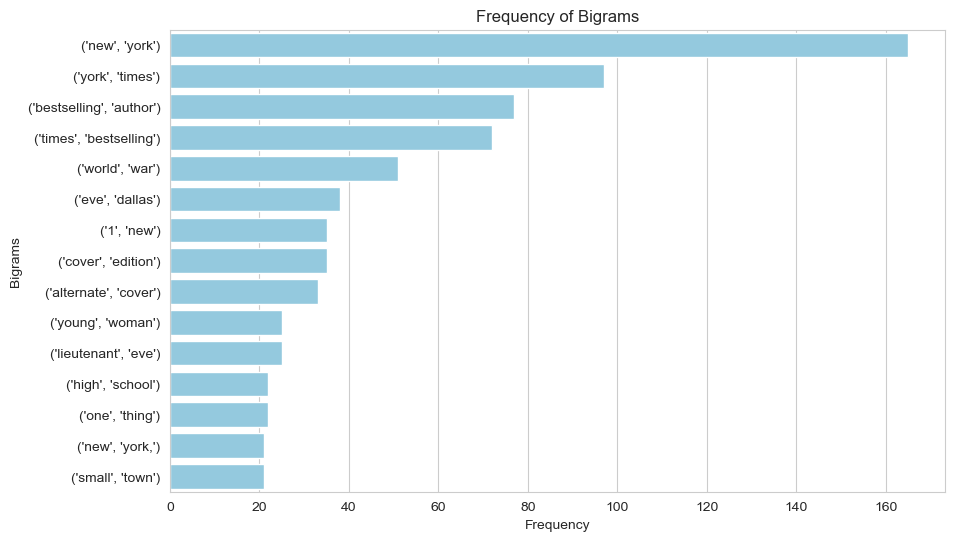

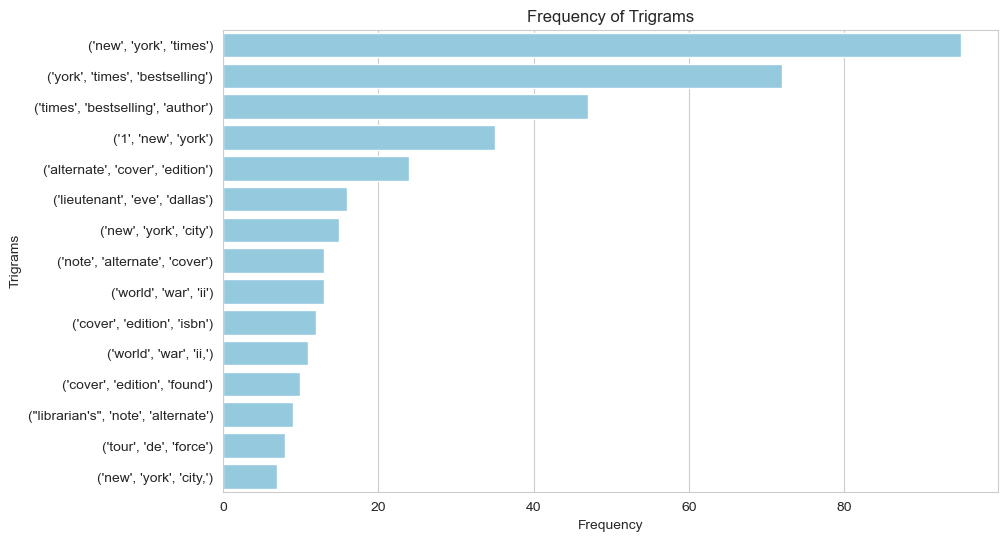

In [6]:
explore.explore_question_2(train)

In [7]:
train['successful'].value_counts()

False    2956
True      128
Name: successful, dtype: int64

In [8]:
train['successful'].value_counts(normalize=True)

False    0.958495
True     0.041505
Name: successful, dtype: float64

In [9]:
train['successful'].value_counts(normalize=True).apply(lambda x: "{:.2%}".format(x))

False    95.85%
True      4.15%
Name: successful, dtype: object

In [10]:
train['sentiment'].value_counts(normalize=True)

very positive    0.496433
very negative    0.333333
positive         0.084306
negative         0.079442
neutral          0.006485
Name: sentiment, dtype: float64

In [16]:
def sentiment_by_success_percent(train):
    total_rows = len(train)
    sentiment_counts = train['sentiment'].value_counts(normalize=True)

    output = pd.DataFrame({'Sentiment': sentiment_counts.index, 'Proportion': sentiment_counts.values})
    output['True'] = output['Proportion'] * total_rows

    false_prop = (total_rows - output['True']) / (total_rows - 1)
    output['False'] = false_prop

    output['Proportion'] = output['Proportion'].apply(lambda x: "{:.2%}".format(x))
    output['True'] = output['True'].apply(lambda x: "{:.2%}".format(x / total_rows))
    output['False'] = output['False'].apply(lambda x: "{:.2%}".format(x))

    output = output[['Sentiment', 'True', 'False']]
    
    return output

# Testing Sentiment by Sucess as Count

In [30]:
total_rows = len(train)
sentiment_counts = train['sentiment'].value_counts(normalize=True)

In [32]:
total_rows

3084

In [31]:
sentiment_counts

very positive    0.496433
very negative    0.333333
positive         0.084306
negative         0.079442
neutral          0.006485
Name: sentiment, dtype: float64

In [33]:
output = pd.DataFrame({'Sentiment': sentiment_counts.index, 'Proportion': sentiment_counts.values})
output

,Sentiment,Proportion
0,very positive,0.496433
1,very negative,0.333333
2,positive,0.084306
3,negative,0.079442
4,neutral,0.006485


In [34]:
output['Total'] = output['Proportion'] * total_rows

In [35]:
output

,Sentiment,Proportion,Total
0,very positive,0.496433,1531.0
1,very negative,0.333333,1028.0
2,positive,0.084306,260.0
3,negative,0.079442,245.0
4,neutral,0.006485,20.0


In [41]:
total_rows

3084

In [40]:
output['Total']

0    1531.0
1    1028.0
2     260.0
3     245.0
4      20.0
Name: Total, dtype: float64

In [42]:
false_prop = ((total_rows - output['Total']) / (total_rows)) * total_rows
false_prop

0    1553.0
1    2056.0
2    2824.0
3    2839.0
4    3064.0
Name: Total, dtype: float64

In [ ]:
false_prop = (total_rows - output['Total']) / (total_rows - 1)
output['False'] = false_prop

In [ ]:
def sentiment_by_success_interger(train):
    total_rows = len(train)
    sentiment_counts = train['sentiment'].value_counts(normalize=True)

    output = pd.DataFrame({'Sentiment': sentiment_counts.index, 'Proportion': sentiment_counts.values})
    output['True'] = output['Proportion'] * total_rows

    false_prop = (total_rows - output['True']) / (total_rows - 1)
    output['False'] = false_prop

    output['Proportion'] = output['Proportion'].apply(lambda x: "{:.2%}".format(x))
    output['True'] = output['True'].apply(lambda x: "{:.2%}".format(x / total_rows))
    output['False'] = output['False'].apply(lambda x: "{:.2%}".format(x))

    output = output[['Sentiment', 'True', 'False']]
    
    return output

In [19]:
def sentiment_by_success_interger_visual(train):
    df = sentiment_by_success_interger(train)
    # create a pie chart
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(df['True'], labels=df['Sentiment'], autopct='%1.1f%%', startangle=90)
    ax.set_title('Sentiment Analysis')
    plt.show()

In [17]:
sentiment_by_success_percent_df = sentiment_by_success_percent(train)

In [18]:
sentiment_by_success_percent_df

,Sentiment,True,False
0,very positive,49.64%,50.37%
1,very negative,33.33%,66.69%
2,positive,8.43%,91.60%
3,negative,7.94%,92.09%
4,neutral,0.65%,99.38%


In [21]:
sentiment_column_values = sentiment_by_success_percent_df[sentiment_by_success_percent_df.columns[0]]

In [22]:
for i in sentiment_column_values:
    print(i)

very positive
very negative
positive
negative
neutral


In [23]:
success_column_true_sentiment_values = sentiment_by_success_percent_df[sentiment_by_success_percent_df.columns[1]]

In [24]:
success_column_true_sentiment_values

0    49.64%
1    33.33%
2     8.43%
3     7.94%
4     0.65%
Name: True, dtype: object

In [25]:
success_column_false_sentiment_values = sentiment_by_success_percent_df[sentiment_by_success_percent_df.columns[2]]

In [26]:
success_column_false_sentiment_values

0    50.37%
1    66.69%
2    91.60%
3    92.09%
4    99.38%
Name: False, dtype: object

In [27]:
for i in success_column_false_sentiment_values:
    print(i)

50.37%
66.69%
91.60%
92.09%
99.38%


In [28]:
for i in success_column_true_sentiment_values:
    print(i)

49.64%
33.33%
8.43%
7.94%
0.65%


In [44]:
sizes = train['successful'].value_counts(normalize=True)
sizes

False    0.958495
True     0.041505
Name: successful, dtype: float64

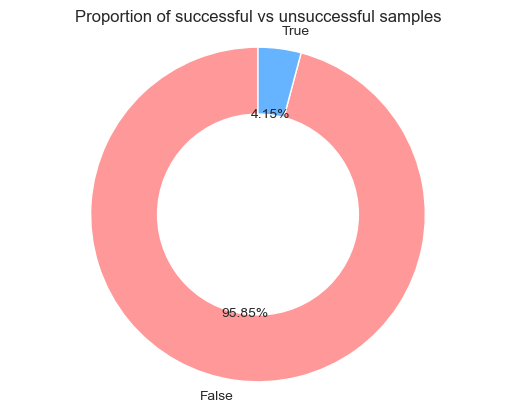

In [29]:
# data
sizes = train['successful'].value_counts(normalize=True)

# colors
colors = ['#ff9999','#66b3ff']

# plot
plt.pie(sizes, labels=sizes.index, colors=colors, autopct='%1.2f%%', startangle=90)

# add circle at center to make it a donut chart
circle = plt.Circle(xy=(0,0), radius=0.6, facecolor='white')
plt.gca().add_artist(circle)

# equal aspect ratio to make it a perfect circle
plt.axis('equal')

# title
plt.title('Proportion of successful vs unsuccessful samples')

# show plot
plt.show()